In [1]:
import numpy as np
from skimage import io, transform, color
from matplotlib import pyplot as plt
import scipy.ndimage as nd

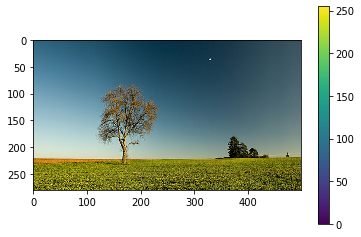

In [2]:
countryside = io.imread('countryside.jpg').astype(np.uint8)
countryside_copy = countryside.copy()
plt.imshow(countryside)
plt.colorbar()

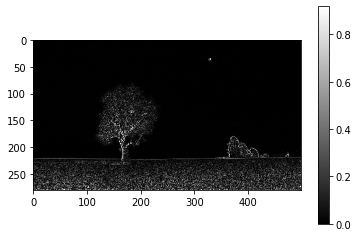

In [3]:
def gradient(img):
    #dx = nd.sobel(color.rgb2gray(img), 0)
    #return np.abs(dx)
    gray_img = color.rgb2gray(img)
    M = np.array(gray_img).astype(np.float)
    gX,gY = np.gradient(M)
    return np.abs(gX)+np.abs(gY)

plt.imshow(gradient(countryside), cmap='gray')
plt.colorbar()

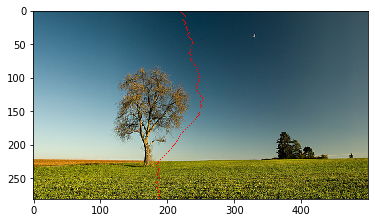

In [4]:
def markPath(mat, path, mark_as='red'):
    assert mark_as in ['red','green','blue','black','white']
    
    if len(mat.shape) == 2:
        mat = color.gray2rgb(mat)
    
    ret = np.zeros(mat.shape)
    ret[:,:,:] = mat[:,:,:]
    
    # Preprocess image
    if np.max(ret) < 1.1 or np.max(ret) > 256: # matrix is in float numbers
        ret -= np.min(ret)
        ret /= np.max(ret)
        ret *= 256
    
    # Determinate components
    if mark_as == 'red':
        r,g,b = 255,0,0
    elif mark_as == 'green':
        r,g,b = 0,255,0
    elif mark_as == 'blue':
        r,g,b = 0,0,255
    elif mark_as == 'white':
        r,g,b = 255,255,255
    elif mark_as == 'black':
        r,b,b = 0,0,0

    # Place R,G,B
    for i in path:
        ret[int(i[0]),int(i[1]),0] = r
        ret[int(i[0]),int(i[1]),1] = g
        ret[int(i[0]),int(i[1]),2] = b
    return ret.astype('uint8')

def backtracking(M):
    
    M2 = np.zeros((M.shape[0],2))
    
    minValRow = np.min(M[M.shape[0]-1,:])
    minValPos = np.where(minValRow==M[M.shape[0]-1,:])
    row,col = M.shape[0]-1,minValPos[0][0]
    while(row!=-1):
        M2[row,0] = row
        M2[row,1] = col
        if(col==0):
            minValRow = min(M[row-1,col],M[row-1,col+1])
            minValPos = np.where(minValRow==M[row-1,col:(col+2)])
            col = col+minValPos[0][0]
        elif(col==M.shape[1]-1):
            minValRow = min(M[row-1,col],M[row-1,col-1])
            minValPos = np.where(minValRow==M[row-1,(col-1):(col+1)])
            col = col+(minValPos[0][0]-1)
        else:
            minValRow = min(M[row-1,col],M[row-1,col-1],M[row-1,col+1])
            minValPos = np.where(minValRow==M[row-1,(col-1):(col+2)])
            col = col+(minValPos[0][0]-1)
        row-=1
    #print("backtracking M2: ", M2.shape)
    #print(M2)
    return M2

def lines(img):
    grad = gradient(img)
    size_X, size_Y = grad.shape
    M = np.zeros((size_X,size_Y))
    #print("Lines M:", M.shape)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if(i==0):
                M[i,j]=grad[i,j]
            else:
                if(j >= M.shape[1]-1):
                    M[i,j] = grad[i,j]+min(M[i-1,j-1],M[i-1,j])
                else:
                    M[i,j] = grad[i,j]+min(M[i-1,j-1],M[i-1,j],M[i-1,j+1])
                    
    return backtracking(M)


def reduce(img,path):
    reducedImg = np.zeros((img.shape[0],img.shape[1]-1,img.shape[2]),dtype=np.uint8)
    idxs = [int(pos[0])*img.shape[1]+int(pos[1]) for pos in path]
    for i in range(img.shape[2]):
#         mask = np.ones_like(img[:,:,i],bool)
#         for idx in path:
#             mask[int(idx[0]),int(idx[1])] = False
#         reducedImg[:,:,i] = img[:,:,i][mask].reshape(reducedImg.shape[0],reducedImg.shape[1])
        reducedImg[:,:,i] = np.reshape(np.delete(img[:,:,i],idxs),(reducedImg.shape[0],reducedImg.shape[1]))
    return reducedImg

def extend(img,path):
    resultImg = np.zeros((img.shape[0],img.shape[1]+1,img.shape[2]),dtype=np.uint8)
    idxs = [int(pos[0])*img.shape[1]+int(pos[1]) for pos in path]
    for i in range(img.shape[2]):
        values = [img[:,:,i][int(pos[0]),int(pos[1])] for pos in path]
        resultImg[:,:,i] = np.reshape(np.insert(img[:,:,i],idxs, values),(resultImg.shape[0],resultImg.shape[1]))
    return resultImg

plt.imshow(markPath(countryside, lines(countryside), mark_as='red'))

In [23]:
print(countryside_copy.shape)
for nlines in range(80):
    line_to_delete = lines(countryside)
    #img_with_line = markPath(countryside, lines_to_delete, mark_as='red')
    countryside = reduce(countryside, line_to_delete)
    #plt.show()
    #plt.imshow(img_with_line)

(281, 500, 3)


(281, 420, 3)
0 255


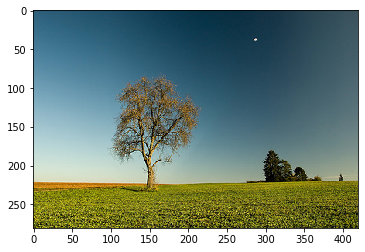

In [24]:
print(countryside.shape)
print(np.min(countryside), np.max(countryside))
plt.imshow(countryside)
plt.show()

(281, 500, 3)


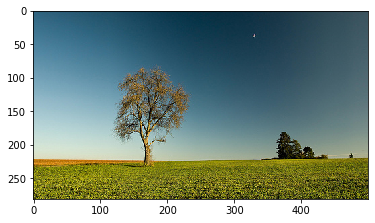

In [26]:
print(countryside_copy.shape)
plt.imshow(countryside_copy)
plt.show()

255 0


<IPython.core.display.Javascript object>


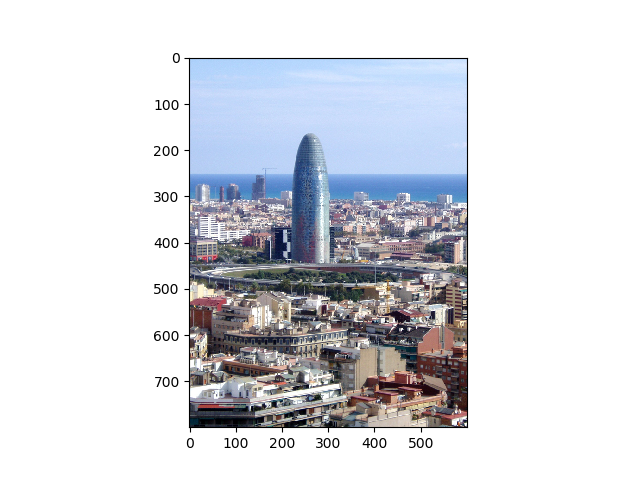

In [5]:
%matplotlib notebook

agbar = plt.imread('agbar.png')
agbar = (agbar*255).astype(np.uint)
print(np.max(agbar), np.min(agbar))
coords = []

def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print ('x = %d, y = %d'%(
        ix, iy))

    global coords
    coords.append([int(ix), int(iy)])

    if len(coords) == 2:
        fig.canvas.mpl_disconnect(cid)

    return coords


fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(agbar)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [39]:
%matplotlib inline

print(coords)

def linesElimination(img, c):
    
    grad = gradient(img)
    for i in range(c[0][0],c[1][0]-1):
        for j in range(c[1][1],c[0][1]-1):
            grad[i,j]=-100
            print(grad[i,j])
    grad = grad

    plt.imshow(grad, cmap='gray')
    plt.show()
    size_X, size_Y = grad.shape
    M = np.zeros((size_X,size_Y))
    #print("Lines M:", M.shape)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if(i==0):
                M[i,j]=grad[i,j]
            else:
                if(j >= M.shape[1]-1):
                    M[i,j] = grad[i,j]+min(M[i-1,j-1],M[i-1,j])
                else:
                    M[i,j] = grad[i,j]+min(M[i-1,j-1],M[i-1,j],M[i-1,j+1])
                    
    return backtracking(M)


[[210, 445], [307, 159]]


98
[[210, 445], [307, 159]]
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
hola
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-100.0
-

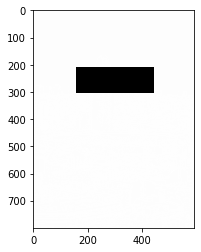

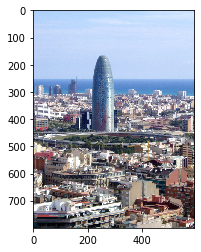

In [40]:
iterations = coords[1][0]-coords[0][0]+1
print(iterations)
for nlines in range(1):
    line_to_delete = linesElimination(agbar, coords)
    #agbar = reduce(agbar, line_to_delete)
    #coords[1][0]=coords[1][0]-1

plt.imshow(agbar)
plt.show()